# LSTM Weather Forecasting (All Features)

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib, warnings
warnings.filterwarnings('ignore')


## 1) Load and preprocess data

In [2]:

# Load dataset
df = pd.read_csv("weatherHistory.csv")

# Parse dates
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True)
df['Formatted Date'] = df['Formatted Date'].dt.tz_localize(None)
df = df.set_index('Formatted Date').sort_index()

# Select useful features
cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
df = df[cols].resample('D').mean().ffill().asfreq('D')

print("Data shape:", df.shape)
df.head()


Data shape: (4019, 6)


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Visibility (km),Pressure (millibars)
Formatted Date,,,,,,
2005-12-31,0.577778,-4.050000,0.890000,17.114300,9.982000,1016.660000
2006-01-01,4.075000,-0.174537,0.817083,21.229192,11.348487,1011.985000
2006-01-02,5.263194,1.808796,0.847083,17.824713,8.492079,1010.384167
2006-01-03,2.340509,0.445370,0.897083,7.726658,9.223958,1021.170833
2006-01-04,2.251852,-0.663194,0.906667,12.152817,8.352546,981.770833


## 2) Scaling and sequence preparation

In [3]:

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
joblib.dump(scaler, "scaler.save")

SEQ_LEN = 30  # same as your uploaded notebook

X, y = [], []
for i in range(len(scaled) - SEQ_LEN):
    X.append(scaled[i:i+SEQ_LEN])
    y.append(scaled[i+SEQ_LEN, 0])  # predict Temperature (C)

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (3989, 30, 6) y shape: (3989,)


## 3) Train/Test split

In [4]:

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (3191, 30, 6) Test size: (798, 30, 6)


## 4) Define and train LSTM model

In [5]:

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

model.save("lstm_model.h5")
print("Model saved as lstm_model.h5")


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0203 - val_loss: 0.0046
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_l

Model saved as lstm_model.h5


## 5) Forecasting and inverse scaling

In [6]:

y_pred = model.predict(X_test)

# Inverse scale
temp_pred = np.hstack([y_pred, np.zeros((len(y_pred), scaled.shape[1]-1))])
y_pred_inv = scaler.inverse_transform(temp_pred)[:,0]

temp_true = np.hstack([y_test.reshape(-1,1), np.zeros((len(y_test), scaled.shape[1]-1))])
y_test_inv = scaler.inverse_transform(temp_true)[:,0]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


## 6) Plot Forecast vs Actual

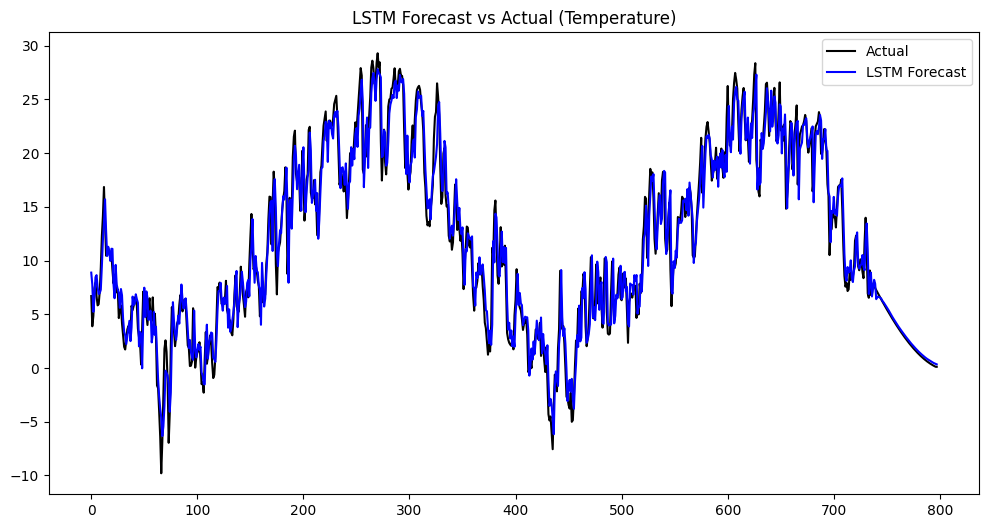

In [7]:

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual", color="black")
plt.plot(y_pred_inv, label="LSTM Forecast", color="blue")
plt.title("LSTM Forecast vs Actual (Temperature)")
plt.legend()
plt.show()


## 7) Metrics

In [8]:

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"LSTM MAE: {mae:.3f}")
print(f"LSTM RMSE: {rmse:.3f}")
print(f"LSTM MAPE: {mape:.2f}%")


LSTM MAE: 1.465
LSTM RMSE: 1.930
LSTM MAPE: 74.38%
